# Multitiers

In [1]:
from pathlib import Path
import os
from pprint import pprint

import multitiers

from IPython.display import display
import graphviz

Multitiers are a novel way of representing linguistic data for purposes of historical investigation and language comparison, mainly in terms of regular correspondences. They can be conceived as an extension to alignments, incorporating information other than segments or sound classes, in ways that are suitable for directly or easily applying most methods of machine learning currently in vogue, particularly those for white-box results such as decision trees.

As mentioned, they initially stem from aligned data. Consider the words "house" /haʊs/ in English, "huis" /ɦœy̯s/ in Dutch, and "hus" /huːs/ in Icelandic, all cognate stemming from a Proto-Germanic "\*hūsą". Their alignment is straightforward, and can be done either manually or with recommended tools such as LingPy:

  | Language  | 1 | 2  | 3 | 4 |
  |-----------|---|----|---|---|
  | English   | h | a  | ʊ | s |
  | Dutch     | ɦ | œ  | y | s |
  | Icelandic | h | uː | - | s |
  
The information under the language names can be considered an essential and the most important tier, and to be clearer we should specify what information they carry (the segments). The indexes, on the other hand, constitute another kind of information, a positional tier, in this case counting left-to-right. We can extend this alignment to a more evident multitier system by clearly marking what are segments and adding positional tiers both left-to-right and right-to-left.

  | Tier Name |  |   |  |  |
  |-----------|---|----|---|---|
  | Index              | 1 |  2 | 3 | 4 |
  | RIndex             | 4 | 3  | 2 | 1 |
  | Segments_English   | h | a  | ʊ | s |
  | Segments_Dutch     | ɦ | œ  | y | s |
  | Segments_Icelandic | h | uː | - | s |
  
Each tier is in fact a variable that a given observation (that is, an alignment site in a cognate set) can assume. It is easier to note this if we transpose the table following common conventions of relational databases, also allowing us to give a unique ID to each position (here, "P" and a number, to distinguish from the index)

  | ID | Index | RIndex | Segment_ENG | Segment_DUT | Segment_ICE |
  |----|-------|--------|-------------|-------------|-------------|
  | P0 | 1     |  4     |  h          | ɦ           | h           |
  | P1 | 2     | 3      | a           | œ           | uː          |
  | P2 | 3     | 2      | ʊ           | y           | -           |
  | P3 | 4     | 1      | s           | s           | s           |
  
This allows us to easily expand with more tiers. We can, for example, incorporate information on the sound class of each site, for each language:

  | ID | Index | RIndex | Segment_ENG | SC_ENG |Segment_DUT  | SC_DUT | Segment_ICE | SC_ICE |
  |----|-------|--------|-------------|--------|-------------|--------|-------------|--------|
  | P0 | 1     |  4     |  h          |   H    | ɦ           |  H     | h           |   H    |
  | P1 | 2     | 3      | a           |   A    | œ           |  U     | uː          |   U    |
  | P2 | 3     | 2      | ʊ           |   U    | y           |   Y    | -           |    -   |
  | P3 | 4     | 1      | s           |   S    | s           |  S     | s           |  S     |
  
This can be extended with essentially any information at hand. For example, we can add for each language an information on the sound class one position before (to the left, L1) for each alignment site. In the table below we do that removing Icelandic, for typesetting reasons.
  
  | ID | Index | RIndex | Segment_ENG | SC_ENG | SC_ENG_L1 |Segment_DUT  | SC_DUT | SC_DUT_L1 |
  |----|-------|--------|-------------|--------|-----------|-------------|--------|-----------|
  | P0 | 1     |  4     |  h          |   H    |    ∅      | ɦ           |  H     | ∅ |
  | P1 | 2     | 3      | a           |   A    |    H      | œ           |  U     | H |
  | P2 | 3     | 2      | ʊ           |   U    |    A      | y           |  Y    | U |
  | P3 | 4     | 1      | s           |   S    |    U      | s           |  S     | Y |
  
The information offered in the tiers can include pretty much anything, despite focusing on sounds and sound classes. While it can technically done by hand, and in fact it is what many people do in their heads when doing historical linguistics, the idea is to use wordlists and employ the tools for assisting the management.

## Loading data

Different kinds of input can be used, including CLDF datasets, but for development purposes we are starting with simpler wordlists as those used by LingPy. Wordlists are plain textual tabular files which must have (1) an unique ID per entry, (2) a COGID id that allows to group different lexemes, (3) a DOCULECT id (or equivalent) that allows to distiguish the different expressions (=lexemes) of each cogid, (4) an ALIGNMENT information with the expression of the lexeme. For the time being, only one entry is allowed for each DOCULECT/COGID pair, but of course it is not necessary for all to be present.

The Germanic dataset in the resources, for example, includes this kind of information:

  | ID     | DOCULECT       | PARAMETER | VALUE    | IPA     | TOKENS      | ALIGNMENT        | COGID |
  |--------|----------------|-----------|----------|---------|-------------|------------------|-------|
  | 1      | Proto-Germanic | \*wīban   | \*wīban  | wiːban  | w iː b a n  | w iː b ( a n )   | 538   |
  | 2      | German         | \*wīban   | Weib     | vaip    | v ai p      | v ai b ( - - )   | 538   |
  | 3      | English        | \*wīban   | wife     | ʋaɪf    | ʋ aɪ f      | ʋ aɪ f ( - - )   | 538   |
  | 4      | Dutch          | \*wīban   | wijf     | ʋɛɪf    | ʋ ɛɪ f      | ʋ ɛɪ f ( - - )   | 538   |
  | 5      | Proto-Germanic | \*kurnan  | \*kurnan | kurnan  | k u r n a n | k u r n ( a n )  | 533   |
  | 6      | German         | \*kurnan  | Korn     | kɔrn    | k ɔ r n     | k ɔ r n ( - - )  | 533   |
  | 7      | English        | \*kurnan  | corn     | kɔːn    | k ɔː n      | k ɔː - n ( - - ) | 533   |
  | 8      | Dutch          | \*kurnan  | koren    | koːrə   | k oː r ə    | k oː r - ( ə - ) | 533   |
  | 9      | Proto-Germanic | \*xaimaz  | \*xaimaz | xaimaz  | x ai m a z  | x ai m ( a z )   | 532   |

We can read the data with the auxiliary function an inspect them:

In [2]:
datafile = Path(os.getcwd()).parent / "resources" / "germanic.tsv"
data_germanic = multitiers.read_wordlist_data(datafile, comma=False)
pprint(data_germanic[:2])

[OrderedDict([('ID', '1'),
              ('DOCULECT', 'Proto-Germanic'),
              ('PARAMETER', '*wīban'),
              ('VALUE', '*wīban'),
              ('IPA', 'wiːban'),
              ('TOKENS', 'w iː b a n'),
              ('ALIGNMENT', 'w iː b ( a n )'),
              ('COGID', '538'),
              ('NOTE', '')]),
 OrderedDict([('ID', '2'),
              ('DOCULECT', 'German'),
              ('PARAMETER', '*wīban'),
              ('VALUE', 'Weib'),
              ('IPA', 'vaip'),
              ('TOKENS', 'v ai p'),
              ('ALIGNMENT', 'v ai b ( - - )'),
              ('COGID', '538'),
              ('NOTE', '')])]


A `MultiTiers` object can be created from such lists of dictionaries, already specifying the sound class model(s) to be used and the left and right context lenghts, if any. If more tiers are needed along the way, they will be added automatically.

In [3]:
mt_germanic = multitiers.MultiTiers(data_germanic, models=['cv'], left=1, right=1)
print(mt_germanic)

A correspondence study can be run by listing all the known and unknown tiers, which can be limited in terms of the values they must include and/or exclude. Consider we want a counter of the sound classes (consonant or vowel) of the second sound in Proto-Germanic lexemes when the initial is /s/. We can prepare the following study:

In [4]:
known1 = {
    'index'                  : {'include': [1]},   # First position in the lexeme...
    'segment_Proto-Germanic' : {'include': ['s']}, # ...when PG has /s/
}
unknown1 = {'cv_Proto-Germanic_R1': {}}

result = mt_germanic.correspondence_study(known1, unknown1)
result

{(1, 's'): {('C',): 78, ('V',): 31}}

Which shows that, in this dataset, there are 31 cases when the initial Proto-Germanic /s/ is followed by a vowel and 78 cases when it is followed by a consonant. Results are easier to interpret with the `print_study` auxiliary function:

In [5]:
multitiers.print_study(result, known1, unknown1)

  index  segment_Proto-Germanic    cv_Proto-Germanic_R1      Count     %  Solved
-------  ------------------------  ----------------------  -------  ----  --------
      1  s                         C                            78  0.72
      1  s                         V                            31  0.28


No entry is marked as solved, as no combination of known tiers results in a fully predictable combination of unknown tiers.

From the literature we know that, in German, initial Proto-Germanic /s/ developed as /z/ when followed by a vowel and as /ʃ/ otherwise, when regular. Let's confirm this:

In [6]:
known2 = {
    'index'                  : {'include': [1]},   # First position in the lexeme...
    'segment_Proto-Germanic' : {'include': ['s']}, # ...when PG has /s/...
    'segment_German'         : {}
}
unknown2 = {'cv_Proto-Germanic_R1': {}}

multitiers.print_study( mt_germanic.correspondence_study(known2, unknown2), known2, unknown2)

  index  segment_Proto-Germanic    segment_German    cv_Proto-Germanic_R1      Count    %  Solved
-------  ------------------------  ----------------  ----------------------  -------  ---  --------
      1  s                         z                 V                            30    1  *
      1  s                         ʃ                 C                            78    1  *


Studies can also be provided as a small programming language, parsed with the `parse_study` function. Here, we illustrate this by investigating another dataset, with Latin and Spanish, to check how palatalization might have worked. The study is "solved", meaning that we obtain a single set of free tiers for the observed bound tiers: all Latin segments /t/ reflected as Spanish /tʃ/ have a consonant one position to the left and a vowel one position to the right.

In [7]:
# TODO: initialize multitier object with filename
datafile = Path(os.getcwd()).parent / "resources" / "latin2spanish.tsv"
data_spanish = multitiers.read_wordlist_data(datafile, comma=False)
mt_spanish = multitiers.MultiTiers(data_spanish, models=['cv'], left=1, right=1)

study = """
KNOWN segment_Latin INCLUDE t
KNOWN segment_Spanish INCLUDE tʃ
UNKNOWN cv_Latin_L1
UNKNOWN cv_Latin_R1
"""
known3, unknown3 = multitiers.utils.parse_study(study)
multitiers.print_study(mt_spanish.correspondence_study(known3, unknown3), known3, unknown3)

segment_Latin    segment_Spanish    cv_Latin_L1    cv_Latin_R1      Count    %  Solved
---------------  -----------------  -------------  -------------  -------  ---  --------
t                tʃ                 C              V                   41    1  *


## Decision trees

One out-of-the-box method for classification offered by the library are decision trees. Let's go back to our Germanic example and check how it can be used:

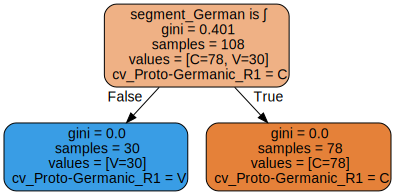

In [8]:
clf1 = multitiers.Classifier(data_germanic, models=['cv'], left=1, right=1)
clf1.train(known2, unknown2)

display(graphviz.Source(clf1.to_dot()))

We can build a more complex example where we use SCA sound classes and try to predict a tuple consisting of the German and English reflexes together. Note that, for simplicity and demonstration, we exclude German /r/ reflexes that are found in the data and we limit to a level three decision tree.

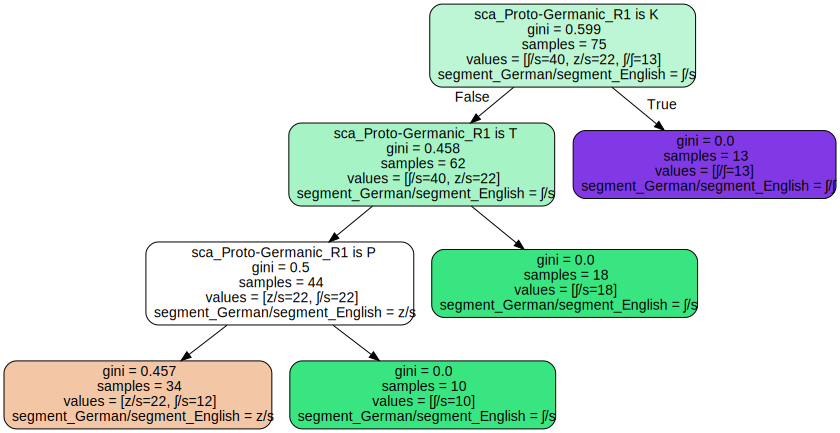

In [12]:
clf2 = multitiers.Classifier(data_germanic, models=['sca'], left=1, right=1)

study = """
X_tier index INCLUDE 1
X_tier segment_Proto-Germanic INCLUDE s
X_tier sca_Proto-Germanic_R1
y_tier segment_German EXCLUDE r
y_tier segment_English
"""

X_tiers2, y_tiers2 = multitiers.utils.parse_study(study)
clf2.train(X_tiers2, y_tiers2, max_depth=3)
display(graphviz.Source(clf2.to_dot()))

We obtain that the most common pair (topmost cell) involves a /ʃ/ reflex in German and a /s/ reflex in English. The first decision found by algorithm is related to the following sound (R1, one position to the right) being of the SCA `K` class (velar sounds in general), for which in all cases both German and English show a /ʃ/ reflex.

If the sound to the right is not a velar consonant, the most informative decision is whether it is of class `T` (dental and alveolars in general). If true, it means that in all cases we observe a /ʃ/, /s/ pair. The third most informative decision is whether the following sound is of class `P` (bilabial consonants), in which case the pair is likewise /ʃ/, /s/. Note that the observed reflexes for P a and T are the same, but as expected from decision trees the decision is not able to group them -- either we use different methods, post-process the output, or create a class that involves both P and T.

No further decision is taken by the tree, as we limited it to three levels. The tree is not able to fully solve the problem, as we end up (in the left bottom corner) with 34 samples. In all cases the English reflex is /s/, but in 22 cases German shows /z/ and in the remaining 12 it shows /ʃ/. Different tiers might have been able to solve the problem with these constrains, but we demonstrate that, using only the SCA sound class of the second sound for s- initials, we cannot fully solve the English/German pair.

An interesting possibility of these trees is to study correspondences of non reconstructed languages. In the example below we try to predict Dutch vowels by using only the corresponding alignment sites in German and English. Instead of limiting by tree-depth, we limit by minimm impurity decrease.

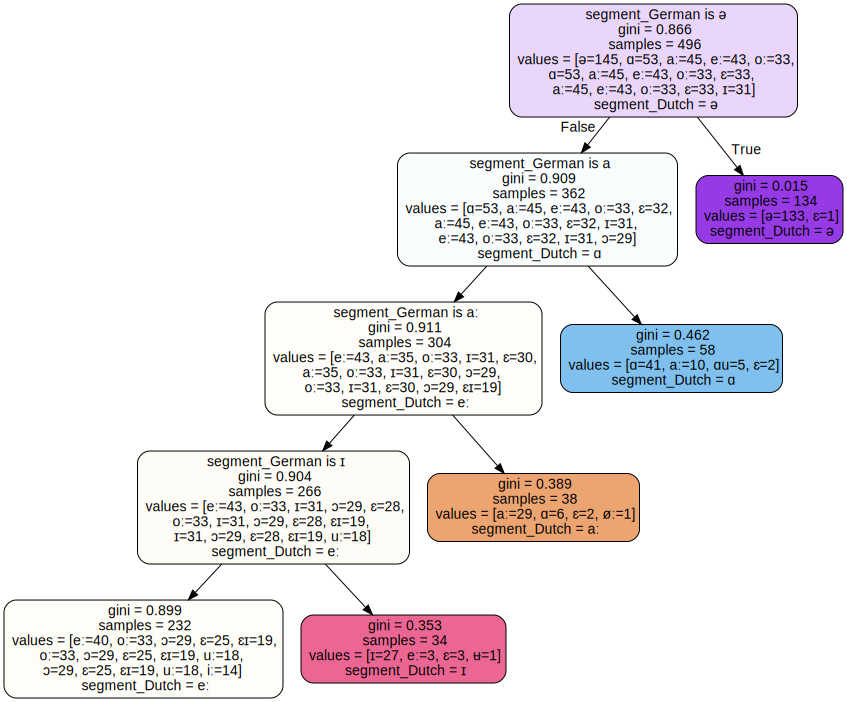

In [13]:
clf3 = multitiers.Classifier(data_germanic, models=['cv'])
study3 = """
X_tier segment_German
X_tier segment_English
X_tier cv_Dutch INCLUDE V
y_tier segment_Dutch
"""
X_tiers3, y_tiers3 = multitiers.utils.parse_study(study3)
clf3.train(X_tiers3, y_tiers3, min_impurity_decrease=0.03333)
display(graphviz.Source(clf3.to_dot()))

We first note that only German tiers were picked, indicating that its tiers have more power of prediction than those of English for this small study. The correspondences are rather clear: German /ə/ always predicts a corresponding Dutch /ə/, German /a/ always predicts a Dutch /ɑ/, German /aː/ always predicts a Dutch /aː/, and German /eː/ always predicts a Dutch /ɪ/. The problem is however far from solved, with 232 samples left and a high 0.899). The fact that no more decision could be collected due to the limit we set indicates that the tiers we are using are in general insufficient for the prediction task: that is, that using *exclusively* the German and English vowel it impossible to predict most of the Dutch ones.

We can make a more advanced experiment by trying to predict Dutch consonantal segments by using the corresponding German and English ones and the sound classes to the left or right. We limit our tree to a 15-level depth.

In [15]:
clf4 = multitiers.Classifier(data_germanic, models=['cv', 'sca'], left=1, right=1)
study4 = """
X_tier segment_German
X_tier segment_English
X_tier sca_German
X_tier sca_German_L1
X_tier sca_German_R1
X_tier sca_English
X_tier sca_English_L1
X_tier sca_English_R1
X_tier cv_Dutch INCLUDE C
y_tier segment_Dutch
"""
X_tiers4, y_tiers4 = multitiers.utils.parse_study(study4)
clf4.train(X_tiers4, y_tiers4, max_depth=15)

Visualizing this tree will not be very helpful, but we check how well it is performing in terms of predictions. Note that we are running on the same dataset we trained it, which makes sense in this case. There is a `show_pred()` method, but here we get the full prediction, including the probability for each one.

In [19]:
clf4.show_pred_prob(max_lines=10)


#0: v/(v|0.973,f|0.027)
#1: r/(r|1.000)
#2: s/(s|1.000)
#3: p/(p|1.000)
#4: r/(r|1.000)
#5: l/(l|1.000)
#6: x/(x|0.519,ɣ|0.160,ʋ|0.086)
#7: h/(h|1.000)
#8: n/(n|1.000)
#9: ŋ/(x|0.519,ɣ|0.160,ʋ|0.086)
#10: b/(b|1.000)


In only one case, #9, this method failed the prediction and in a bad way, as the observed state is not even among the top-three choices. In a number of cases, the observed state was predicted with full certainty.

The library also offers methods for feature extraction. Let's consider the Latin Spanish example above, but also with feature extraction.

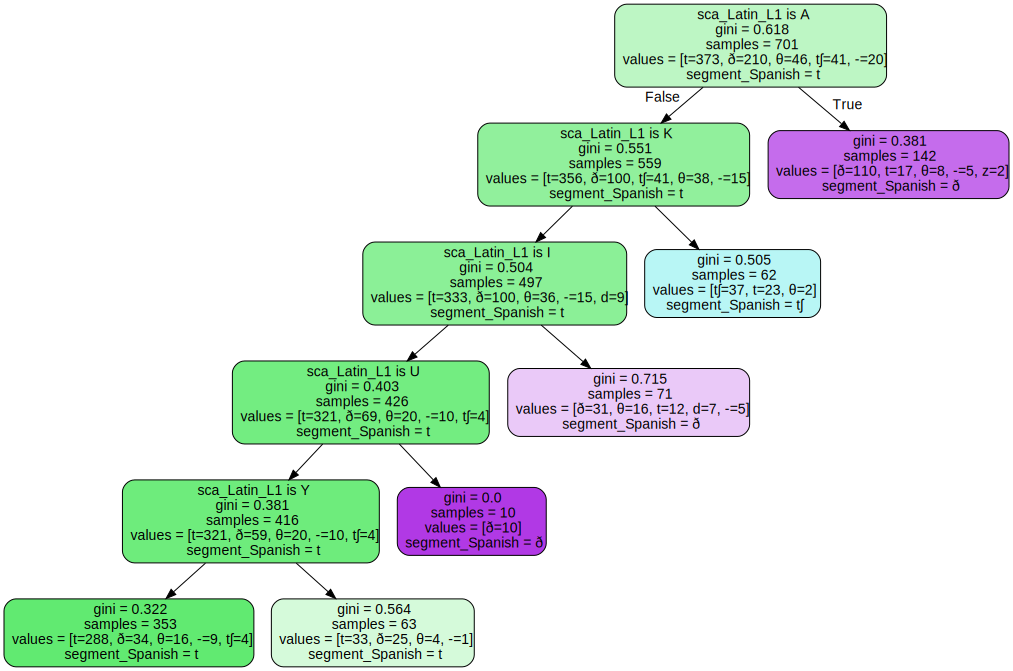

In [20]:
clf5 = multitiers.Classifier(data_spanish, models=['sca'], left=1, right=1)
study = """
X_tier segment_Latin INCLUDE t
X_tier sca_Latin_L1
Y_tier sca_Latin_R1
y_tier segment_Spanish
"""
X_tiers5, y_tiers5 = multitiers.utils.parse_study(study)
clf5.train(X_tiers5, y_tiers5)
display(graphviz.Source(clf5.to_dot()))

In [22]:
clf5.feature_extraction("tree", num_feats=5)

[('sca_Latin_L1_A', 0.3296542422158415),
 ('sca_Latin_L1_K', 0.1379649920635418),
 ('sca_Latin_L1_S', 0.12830058995556023),
 ('sca_Latin_L1_I', 0.09016712760575624),
 ('sca_Latin_L1_N', 0.08446482228946994)]

In [23]:
clf5.feature_extraction("lsvc")

[('sca_Latin_L1_A', True),
 ('sca_Latin_L1_K', True),
 ('sca_Latin_L1_N', True),
 ('sca_Latin_L1_S', True)]